In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import datetime
from tensorflow.keras import datasets, layers, models, losses, Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import TensorBoard
import logging

# !export CUDA_VISIBLE_DEVICES=1

2023-04-24 15:34:10.067392: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-24 15:34:10.098721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 15:34:10.546926: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

gpus = tf.config.list_physical_devices('GPU')

tf.config.set_visible_devices(gpus[-1], 'GPU')



2023-04-24 15:34:11.315605: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-24 15:34:11.315782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-24 15:34:11.338105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
# Remove prior tensor logs from the log file
! rm -rf ./logs/*

/bin/bash: /home/metaverse/miniconda3/envs/mutiah/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [3]:
def image_reshape(xtrain, xtest):
    x_train = tf.pad(xtrain, [[0, 0], [2,2], [2,2]])/255
    x_test = tf.pad(xtest, [[0, 0], [2,2], [2,2]])/255

    x_train = tf.expand_dims(x_train, axis=3, name=None)
    x_test = tf.expand_dims(x_test, axis=3, name=None)
    
    x_train = tf.repeat(x_train, 3, axis=3)
    x_test = tf.repeat(x_test, 3, axis=3)
    
    
    return x_train, x_test

In [4]:
with tf.device('/device:GPU:1'):
    # Reshape image 
    (x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()
    x_train, x_test = image_reshape(x_train, x_test)

    # Divide training dataset into training and validation sets
    x_val = x_train[-2000:,:,:]
    y_val = y_train[-2000:]
    x_train = x_train[:-2000,:,:]
    y_train = y_train[:-2000]
    print(x_train.shape)
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)
    print(x_val.shape)
    print(y_val.shape)

2023-04-24 15:34:14.889215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-24 15:34:14.889355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-24 15:34:14.889412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(58000, 32, 32, 3)
(58000,)
(10000, 32, 32, 3)
(10000,)
(2000, 32, 32, 3)
(2000,)


In [5]:
def identity_block(x, filter): 

    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = layers.Conv2D(filter, kernel_size = (3,3), padding = 'same')(x)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation('relu')(x)
    # Layer 2
    x = layers.Conv2D(filter, kernel_size =(3,3), padding = 'same')(x)
    x = layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = layers.Add()([x, x_skip])     
    x = layers.Activation('relu')(x)
    return x

In [6]:
def convolutional_block(x, filter):

    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = layers.BatchNormalization(axis=3)(x)
    x = layers.Activation('relu')(x)
    # Layer 2
    x = layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = layers.Add()([x, x_skip])     
    x = layers.Activation('relu')(x)
    return x

In [7]:
def ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = layers.Input(shape)
    x = layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # he filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation = 'relu')(x)
    x = layers.Dense(classes, activation = 'softmax')(x)
    model = Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [8]:
model = ResNet34()
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [9]:
with tf.device('/device:GPU:1'):
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Define the CSVLogger callback
    csv_logger = tf.keras.callbacks.CSVLogger('training.log')

    callbacks = [tensorboard_callback, csv_logger]
    history = model.fit(x_train, y_train, batch_size=64, epochs=40, validation_data=(x_val, y_val), callbacks= callbacks)

Epoch 1/40


2023-04-24 15:34:45.750957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-24 15:34:46.550678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-24 15:34:46.552647: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fba22e83710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-24 15:34:46.552664: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-04-24 15:34:46.556021: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-24 15:34:46.635575: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

907/907 [==============================] - 32s 19ms/step - loss: 0.2239 - accuracy: 0.9358 - val_loss: 0.0992 - val_accuracy: 0.9780
Epoch 2/40
907/907 [==============================] - 16s 17ms/step - loss: 0.0799 - accuracy: 0.9783 - val_loss: 0.0508 - val_accuracy: 0.9885
Epoch 3/40
907/907 [==============================] - 16s 17ms/step - loss: 0.0531 - accuracy: 0.9860 - val_loss: 0.0565 - val_accuracy: 0.9835
Epoch 4/40
907/907 [==============================] - 16s 17ms/step - loss: 0.0433 - accuracy: 0.9886 - val_loss: 0.0980 - val_accuracy: 0.9830
Epoch 5/40
907/907 [==============================] - 15s 17ms/step - loss: 0.0430 - accuracy: 0.9886 - val_loss: 0.0433 - val_accuracy: 0.9890
Epoch 6/40
907/907 [==============================] - 16s 17ms/step - loss: 0.0345 - accuracy: 0.9907 - val_loss: 0.0258 - val_accuracy: 0.9925
Epoch 7/40
907/907 [==============================] - 15s 17ms/step - loss: 0.0334 - accuracy: 0.9912 - val_loss: 0.0338 - val_accuracy: 0.9935
Epo

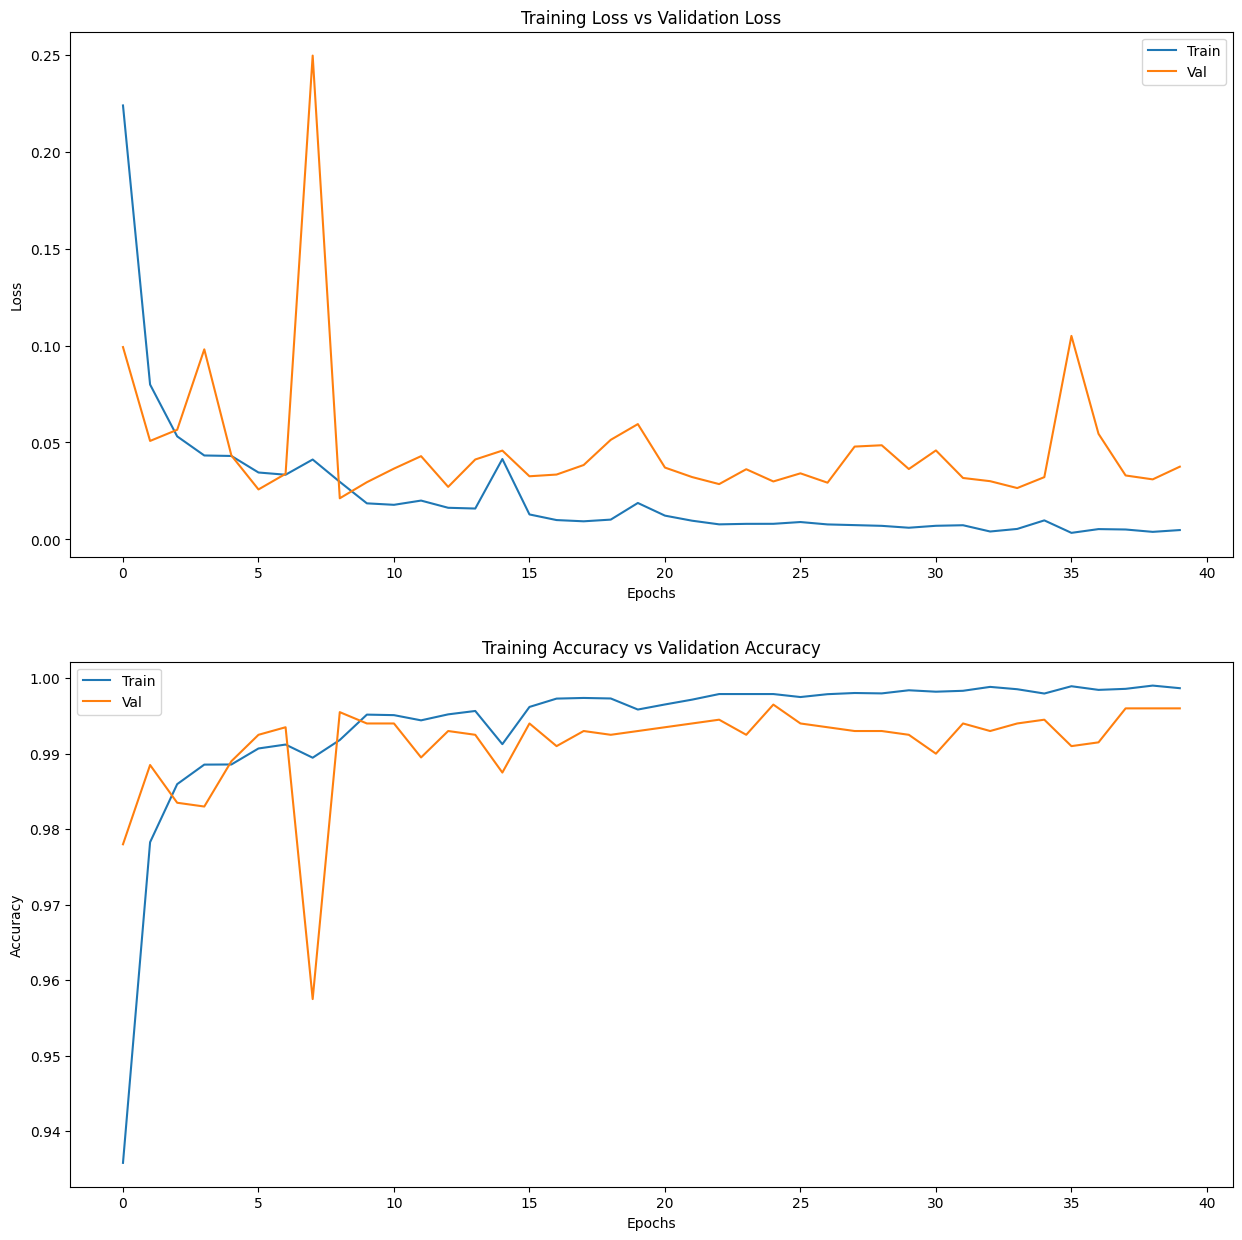

In [10]:
# Plot of accuracy and loss
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [11]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.0376 - accuracy: 0.9942


[0.03755645453929901, 0.9941999912261963]

In [14]:
%reload_ext tensorboard
%tensorboard --logdir ./logs/fit --port 8006